In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
data = np.asarray([4.0711935574242422E-002, 0.12192594164540538, 0.20271856240250444, 0.28308646415814365, 0.36302642280015546])
x, step = np.linspace(-1, 1, 50, retstep=True)

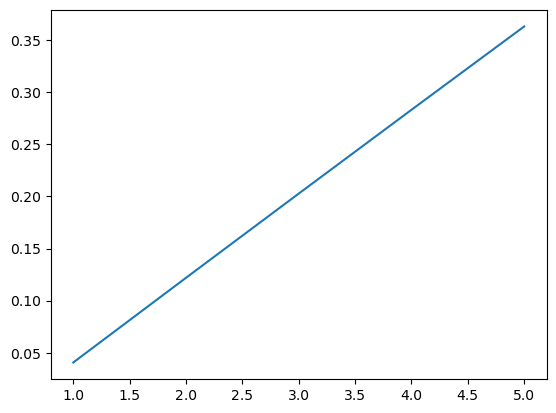

In [3]:
plt.plot([1, 2, 3, 4, 5], data)

In [4]:
(data[-1] - data[0])/5

0.0644628974451826

In [7]:
func = np.loadtxt('./prova.txt')
func.shape

(50, 50)

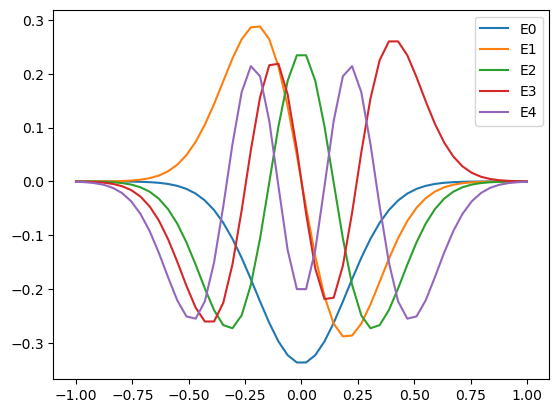

In [22]:
fig, ax = plt.subplots()
for i in range(5):
    ax.plot(x, func[:, i], label=f'E{i}')

ax.legend()
fig.show()

In [25]:
func[:,0].sum()*step

-0.17080862622327872